In [299]:
import pandas as pd
import quandl, math
import numpy as np

import datetime

import matplotlib.pyplot as plt

from matplotlib import style
from sklearn import preprocessing, cross_validation, svm
from sklearn.linear_model import LinearRegression

style.use('ggplot')

quandl.ApiConfig.api_key = "Yx2Q5Mho6nhmLFsuPBY8"
df = quandl.get('WIKI/GOOGL')

In [300]:
print(df.head())

              Open    High     Low    Close      Volume  Ex-Dividend  \
Date                                                                   
2004-08-19  100.01  104.06   95.96  100.335  44659000.0          0.0   
2004-08-20  101.01  109.08  100.50  108.310  22834300.0          0.0   
2004-08-23  110.76  113.48  109.05  109.400  18256100.0          0.0   
2004-08-24  111.24  111.60  103.57  104.870  15247300.0          0.0   
2004-08-25  104.76  108.00  103.88  106.000   9188600.0          0.0   

            Split Ratio  Adj. Open  Adj. High   Adj. Low  Adj. Close  \
Date                                                                   
2004-08-19          1.0  50.159839  52.191109  48.128568   50.322842   
2004-08-20          1.0  50.661387  54.708881  50.405597   54.322689   
2004-08-23          1.0  55.551482  56.915693  54.693835   54.869377   
2004-08-24          1.0  55.792225  55.972783  51.945350   52.597363   
2004-08-25          1.0  52.542193  54.167209  52.100830   53.1

In [301]:
# Limit Dataframe to just these columns
df = df[['Adj. Open', 'Adj. High', 'Adj. Low', 'Adj. Close', 'Adj. Volume']]

# Calculate the high/low percentage + percent change
df['HL_PCT'] = (df['Adj. High'] - df['Adj. Low']) / df['Adj. Close'] * 100.0
df['PCT_CHANGE'] = (df['Adj. Close'] - df['Adj. Open']) / df['Adj. Open'] * 100.0

df = df[['Adj. Close', 'HL_PCT', 'PCT_CHANGE', 'Adj. Volume']]
print(df.head())

            Adj. Close    HL_PCT  PCT_CHANGE  Adj. Volume
Date                                                     
2004-08-19   50.322842  8.072956    0.324968   44659000.0
2004-08-20   54.322689  7.921706    7.227007   22834300.0
2004-08-23   54.869377  4.049360   -1.227880   18256100.0
2004-08-24   52.597363  7.657099   -5.726357   15247300.0
2004-08-25   53.164113  3.886792    1.183658    9188600.0


In [302]:
# Declare the column of interest for labeling, Adjusted Close
forecast_col = 'Adj. Close'

# Replace any nan's with a number
df.fillna(-99999, inplace=True)

# Determine how far "out" to predict
forecast_out = int(math.ceil(0.01*len(df)))

# Create a new column that equals the Adjusted close, 0.01*len(df) in the future
df['label'] = df[forecast_col].shift(-forecast_out)
#print(df.tail())


X = np.array(df.drop(['label'], 1))
X = preprocessing.scale(X)
X = X[:-forecast_out]
X_lately = X[-forecast_out:]

df.dropna(inplace=True)
y = np.array(df['label'])
y = np.array(df['label'])

#print(len(X), len(X_lately), len(y))

X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y, test_size=0.2)

clf = LinearRegression(n_jobs=-1)
clf.fit(X_train, y_train)

accuracy = clf.score(X_test, y_test)
print('Model Accuracy: {}'.format(accuracy))

forecast_set = clf.predict(X_lately)
print(forecast_set, accuracy, forecast_out)

Model Accuracy: 0.9751176518962865
[  951.99887747   963.45234662   969.71954589   965.02562684   973.83233868
   971.85567766   970.37246226   971.44249919   970.70458803   974.61520406
   980.47010401   954.89254365   965.52775445   970.19266671   979.82093745
   985.77448087   993.46269     1006.72628863  1008.72131674  1012.08063797
  1001.03610088  1003.32124724  1011.7902422   1019.34249821  1011.30400842
  1017.32826007  1019.72747985   978.3795432    973.90668524   984.82390533
   981.62318715   974.45831104   973.37344954] 0.975117651896 33


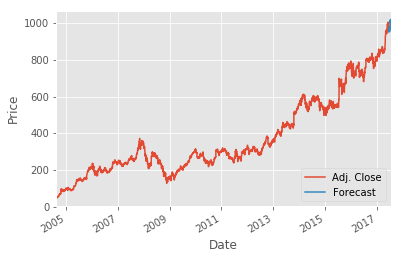

In [303]:
df["Forecast"] = np.nan
last_date = df.iloc[-1].name
last_unix = last_date.timestamp()
one_day = 86400
next_unix = last_unix + one_day

for i in forecast_set:
    next_date = datetime.datetime.fromtimestamp(next_unix)
    next_unix += one_day
    df.loc[next_date] = [np.nan for _ in range (len(df.columns)-1)] + [i]
    
df['Adj. Close'].plot()
df['Forecast'].plot()
plt.legend(loc=4)
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()